In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np 
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import itertools
import warnings
import scipy.signal as sp
import math
from statsmodels.tsa.stattools import acf, pacf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import datetime
import statistics
from sklearn import linear_model

C:\Users\trevo\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
#build baseline equation
total = pd.concat([demand2016])
total = pd.merge(total,temp,how='inner', left_index=True, right_index=True)
X1 = total.drop(['Total','Toronto'],axis = 1)
Y =  total['Total']
clf = linear_model.Lasso(alpha = 0.1) #.LinearRegression()
clf.fit(X1, Y)
print(clf.score(X1,Y))

baseline = clf.coef_[0]*temp['CDD'] + clf.coef_[0]*temp['HDD'] + clf.intercept_



plt.plot(demand2017['2017'])
plt.plot(baseline['2017'])

In [2]:
def convert_datetime(dTot):
    
    dTot['Date_Hour'] = pd.to_datetime(dTot.Date) + pd.to_timedelta(dTot.Hour, unit='h')
    
    
    
    dTot = dTot.drop(['Date','Hour'],axis = 1)
    dTot = dTot.set_index('Date_Hour')
    
    return dTot

In [3]:
#weather normalize data

#importanting weather data
temp = pd.read_csv("temperature.csv", usecols = [0,26], parse_dates=["datetime"], index_col="datetime")
#convert to degrees celsius
temp = temp - 273.15


#calcualte HDD/CDD
talpha = 14 #temp where correlation between temperature and demand inverts
tbeta = 14

temp['CDD'] = (((temp['Toronto'].resample('D').max()+temp['Toronto'].resample('D').min())/2-talpha))
temp['HDD'] = ((tbeta-(temp['Toronto'].resample('D').max()+temp['Toronto'].resample('D').min())/2))
temp.CDD[temp.CDD < 0] = 0
temp.HDD[temp.HDD < 0] = 0

print(temp['2012-10-02':].resample('D').mean())

              Toronto       CDD     HDD
datetime                               
2012-10-02  14.247390  0.821158   0.000
2012-10-03  14.176875  0.580000   0.000
2012-10-04  15.067917  1.140000   0.000
2012-10-05  16.216458  2.915000   0.000
2012-10-06  15.725417  2.135000   0.000
2012-10-07  10.197083  0.000000   2.820
2012-10-08   6.796250  0.000000   7.600
2012-10-09   6.735000  0.000000   7.105
2012-10-10   9.305417  0.000000   4.270
2012-10-11  11.011250  0.000000   3.300
2012-10-12   6.651667  0.000000   6.625
2012-10-13   7.841667  0.000000   5.945
2012-10-14   4.308333  0.000000   9.765
2012-10-15  12.561250  0.000000   0.885
2012-10-16  12.780833  0.000000   1.850
2012-10-17   7.649167  0.000000   6.015
2012-10-18   8.604167  0.000000   4.775
2012-10-19  11.895417  0.000000   1.315
2012-10-20  10.315000  0.000000   3.160
2012-10-21   9.593125  0.000000   4.180
2012-10-22  11.098125  0.000000   1.785
2012-10-23  11.051875  0.000000   1.605
2012-10-24  10.771250  0.000000   2.640


In [4]:
#1 day ahead
forecast_length = 1
print(len(demand2017))

NameError: name 'demand2017' is not defined

In [5]:
def test_model (train, test, i):

    #convert by log
    #print(train[i])
    #print(test[i])
    
    #dTot_train_log = np.log(train[i]) # change
   
    #seasonal differencing
    seasons = 12
    #dTot_train_log_ewma = dTot_train_log - dTot_train_log.shift(seasons)
    
    #fit model
    mod = sm.tsa.statespace.SARIMAX(train[i],
                                    order=(1, 1, 0),
                                    seasonal_order=(0, 0, 0, seasons),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()

 
    #forecast
    forecast = pd.Series(results.get_forecast(steps = forecast_length).predicted_mean, copy = True)
    #forecast_log_diff = pd.Series(results.get_forecast(steps = forecast_length).predicted_mean, copy = True)
    #forecast_log_diff.index  = test[i].index #.resample('D').mean()
    
    #Remove differencing 
    #forecast_log =  forecast_log_diff + dTot_train_log.shift(seasons).iloc[len(train[i])-1] #try mean?
    
    #Remove log
    #forecast =  pd.Series(np.exp(forecast_log), index=forecast_log.index)
    
    
    #print(forecast)
    #plt.plot(forecast)
    #print(forecast)
    #plt.plot(test[i])
    #print(test[i])
    #plt.legend(['Forecast','Test'])

    #AIC = results.aic
    #RMSE = (forecast - test[i].Total).abs()
    #RMSE = math.sqrt((((forecast - test[i].Total)**2).mean())) 

    #print('AIC:')
    #print(AIC)
    #print('RMSE:')
    #print(RMSE)

    #plt.plot(dTot_train_log_ewma)
    #Plot auto and partial correlation
    #fig = plt.figure(figsize=(12,8))
    #ax1 = fig.add_subplot()
    #fig = sm.graphics.tsa.plot_acf(dTot_train_log_ewma, lags=40, ax=ax1)
    #ax2 = fig.add_subplot()
    #fig = sm.graphics.tsa.plot_pacf(dTot_train_log_ewma, lags=40, ax=ax2)

    return forecast

In [6]:
#Spilt into train/test
train = []
test = []
results = []

start = 0 #if 1 delete append 2017 in train, remember to change for loop length i.e 260 if 1

ctr = start+forecast_length #forecast_length

train.append(temp['2012-10-02':'2016-12-31'].CDD.resample('D').mean()) #,demand2017.iloc[0:130] summer only
test.append(temp['2017':].CDD.resample('D').mean().iloc[[start]]) #[0:forecast_length]
results.append(test_model(train,test,0))

#int(round(260/forecast_length))

for i in range(1,334): #(1,260) summer only
    
    train.append(train[i-1].append(test[i-1]))
    test.append(temp['2017':].CDD.resample('D').mean().iloc[[ctr]])
    ctr = ctr + forecast_length
    results.append(test_model(train,test,i))
    

1.4288914633756353
0.7405252898100416


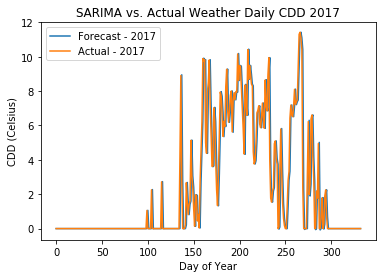

In [10]:
error = []

for i in range(0,334):
    
    error.append((test[i] - results[i]).abs())
    

r1 = 1
r2 = 364
plt.ylabel('CDD (Celsius)')
plt.xlabel('Day of Year')
plt.title('SARIMA vs. Actual Weather Daily CDD 2017')
plt.plot(results[r1:r2])
plt.plot(test[r1:r2])
plt.legend(['Forecast - 2017','Actual - 2017'])

from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test[r1:r2], results[r1:r2]))
print(rms)
print(np.mean(error[r1:r2]))
#print(error)

In [113]:
pd.concat(results).to_csv('SARIMAX_CDD_Forecast')